<a href="https://colab.research.google.com/github/greyhound101/internship/blob/master/fold_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')
drive.mount("/content/gdrive", force_remount=True)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Mounted at /content/gdrive


In [2]:
import zipfile
import h5py
from keras.optimizers import Adam
import cv2
from keras.utils import to_categorical
from matplotlib import pyplot as plt
import glob, os
from matplotlib import pyplot as plt
import h5py
from sklearn.metrics import accuracy_score
import numpy as np
from tqdm import tqdm
import time
import gc
from keras.applications import *
from keras.layers import *
from keras import backend as K
from keras.models import Model

Using TensorFlow backend.


Loading the data

In [0]:
path = F"/content/gdrive/My Drive/check.npy" 
df=np.load(path,allow_pickle=True)
df=df.item()

Function to shuffle data in fold and load each fold

In [0]:

#shuffle samples
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]



#change targets
def change(img):
    resized = cv2.resize(img, (299,299), interpolation = cv2.INTER_AREA )
    return resized




#get train and test splits
def get_trn_tst(df,tst_fold):
  idx=np.asarray(df['fold'])
  y=np.asarray(df['label'])
  y-=1
  img=np.asarray(df['image'])
  img1=[]
  for i in range(len(img)):
        img1.append(change(img[i]))
  img1=np.asarray(img1)
  del([img])
  gc.collect()
  trn_y=np.asarray(y[(idx!=tst_fold)])
  trn_img=np.asarray(img1[(idx!=tst_fold)])
  tst_y=np.asarray(y[(idx==tst_fold)])
  tst_img=img1[idx==tst_fold]
  trn_img=np.repeat(trn_img.reshape((trn_img.shape[0],299,299,1)),3,axis=3)
  tst_img=np.repeat(tst_img.reshape((tst_img.shape[0],299,299,1)),3,axis=3)
  return (trn_img.copy(),trn_y.copy()),(tst_img.copy(),tst_y.copy())

Verfying model stricture

In [5]:

mod=InceptionV3(include_top=True, weights='imagenet')
mod.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
_______________________________________________________________________________________

Function to load model

In [0]:

def load_model(last=True):   
  K.clear_session() 
  mod=InceptionV3(include_top=True, weights='imagenet')
  out_1=mod.layers[-2].output
  out=Dense(3,activation='softmax')(out_1)
  model=Model(inputs=mod.input,outputs=out)

  if last:
    for i in range(len(model.layers)):
        model.layers[i].trainable = False
  model.layers[-1].trainable=True
  return model

In [0]:
import keras
import pandas as pd
from keras.applications.nasnet import NASNetMobile, preprocess_input
import imgaug as ia
from imgaug import augmenters as iaa
def Hflip( images):
		seq = iaa.Sequential([iaa.Fliplr(1.0)])
		return seq.augment_images(images)
def Vflip( images):
		seq = iaa.Sequential([iaa.Flipud(1.0)])
		return seq.augment_images(images)
def rotate( images):
		seq = iaa.Sequential(
				[iaa.Affine(rotate=(-15, 15),mode=ia.ALL)])
		return seq.augment_images(images)
def noise( images):
		seq = iaa.Sequential([iaa.AdditiveGaussianNoise(loc=0,scale=(0, 0.05 *np.mean(images)),per_channel=0.5)])
		return seq.augment_images(images)

class DataGenerator(keras.utils.Sequence):
  def __init__(self, images, labels, batch_size=64, image_dimensions = (96 ,96 ,3), shuffle=False, augment=False):
    self.labels       = labels              # array of labels
    self.images = images        # array of image paths
    self.batch_size   = batch_size          # batch size
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(self.labels.shape[0] / self.batch_size))

  def on_epoch_end(self):
    self.indexes = np.arange(self.labels.shape[0])

  def __getitem__(self, index):
		# selects indices of data for next batch
    indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
    # select data and load images
    labels = self.labels.loc[indexes]
    img = [self.images[k].astype(np.float32) for k in indexes]
    imgH=Hflip(img)
    imgV=Vflip(img)
    imgR=rotate(img)
    imgN=noise(img)
    images=img.copy()
    images.extend(imgH)
    images.extend(imgV)
    images.extend(imgR)
    images.extend(imgN)
  
    lbl=labels.copy()
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    labels=pd.concat([labels,lbl],0)
    #images = np.array([preprocess_input(img) for img in images])
    return np.asarray(images), labels

In [0]:
a,b=get_trn_tst(df,1)

In [0]:
train_data = DataGenerator(a[0],pd.get_dummies(a[1]), batch_size=8, augment=True, shuffle=False)


In [0]:
c,d=train_data.__getitem__(0)

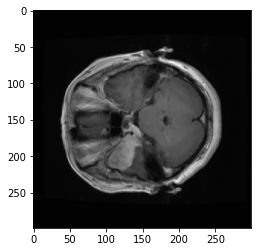

In [11]:

plt.imshow(a[0][0])

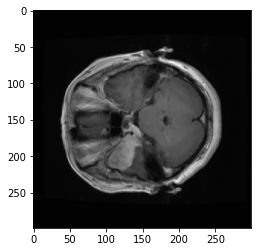

In [12]:

plt.imshow(c[0])


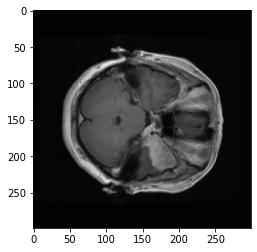

In [13]:

plt.imshow(c[8])

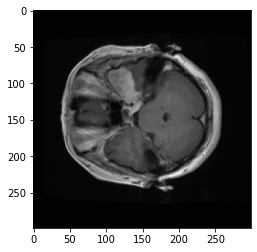

In [14]:

plt.imshow(c[16])

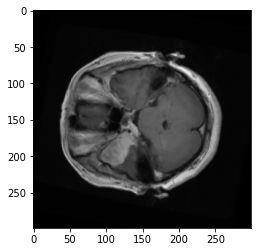

In [15]:

plt.imshow(c[24])

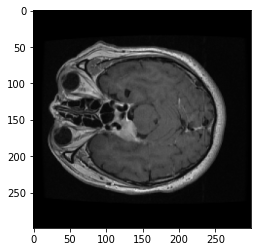

In [16]:

plt.imshow(c[-1])

Dictionaries to store results

In [0]:
best_accuracy_last={}
final_accuracy_last={}
history_last={}
answers_last={}
predictions_last={}
predictions_last_best={}
times_last={}

Make Prediction

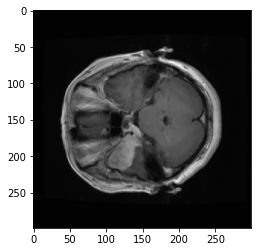

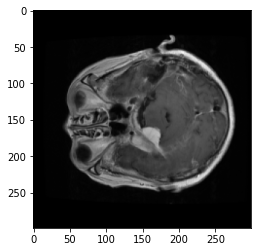

Epoch 1/1
315/315 [==============================] - 62s 197ms/step - loss: 0.8384 - accuracy: 0.6406 - val_loss: 1.2663 - val_accuracy: 0.4539
Epoch 1/1
315/315 [==============================] - 51s 163ms/step - loss: 0.6394 - accuracy: 0.7405 - val_loss: 1.4868 - val_accuracy: 0.4649
Epoch 1/1
315/315 [==============================] - 51s 163ms/step - loss: 0.5685 - accuracy: 0.7698 - val_loss: 1.5271 - val_accuracy: 0.4705
Epoch 1/1
315/315 [==============================] - 51s 163ms/step - loss: 0.5253 - accuracy: 0.7856 - val_loss: 1.9292 - val_accuracy: 0.4668
Epoch 1/1
315/315 [==============================] - 51s 163ms/step - loss: 0.4998 - accuracy: 0.7976 - val_loss: 1.7417 - val_accuracy: 0.4908
Epoch 1/1
315/315 [==============================] - 51s 163ms/step - loss: 0.4889 - accuracy: 0.7981 - val_loss: 1.5652 - val_accuracy: 0.5037
Epoch 1/1
315/315 [==============================] - 52s 164ms/step - loss: 0.4717 - accuracy: 0.8109 - val_loss: 1.6821 - val_accuracy:

398

In [18]:
  def upd(dk,data):
    if dk==0:
        dk=data
    else:
        for ky in data.keys():
            dk[ky].extend(data[ky])
    return dk
  index=1
  epoch=100
  pre_acc=0
  best=0
  fold='fold_'+str(index)
  trn,tst=get_trn_tst(df,index)
  history_last[fold]=0



  plt.imshow(trn[0][0])
  plt.show()
  plt.imshow(tst[0][0])
  plt.show()



  trn_x,trn_y=unison_shuffled_copies(trn[0],trn[1])
  tst_x,tst_y=unison_shuffled_copies(tst[0],tst[1])



  model=load_model()


  
  #compiling the model
  model.compile(optimizer=Adam(3e-4), 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])
  train_data = DataGenerator(trn_x,pd.get_dummies(trn_y), batch_size=8, augment=True)

  
  #fitting the model
  #timing
  start=time.time()
  for i in range(epoch):
      hist=model.fit_generator(train_data,epochs=1,validation_data=[tst_x,to_categorical(tst_y)],steps_per_epoch=len(trn_x)//8,
		                                   )
      pre=model.predict(tst_x)
      pre=np.argmax(pre,1)
      new_acc=accuracy_score(pre,tst_y)
      if new_acc>best:
            best_accuracy_last[fold]=new_acc
            best=new_acc
            predictions_last_best[fold]=pre
      history_last[fold]=upd(history_last[fold],hist.history)

  end=time.time()
  times_last[fold]=end-start

  #getting the prediction 
  pre=model.predict(tst_x)
  



  #select the maximum position
  pre=np.argmax(pre,1)
  predictions_last[fold]=pre

  
  
  
  #getting the accuracy
  new_acc=accuracy_score(pre,tst_y)

  


  #storing the predictions
  final_accuracy_last[fold]=new_acc








  #storing the answers
  answers_last[fold]=tst_y
    
    
    
    
  #freeing memory
  del([trn,tst,trn_x,trn_y,tst_x,tst_y])
  gc.collect()


Time taken for different training methods



In [19]:
print('Time taken for each fold for training last layer = '+str(np.mean(list(times_last.values()))))

Time taken for each fold for training last layer = 5416.688539028168


Mean accuracy for different training methods



In [20]:
print('Best mean results across all folds when training last layer is ='+str(np.mean(list(best_accuracy_last.values()))))
print('Final mean results across all folds when training last layer is ='+str(np.mean(list(final_accuracy_last.values()))))

Best mean results across all folds when training last layer is =0.5424354243542435
Final mean results across all folds when training last layer is =0.5129151291512916


Training loss for different training methods



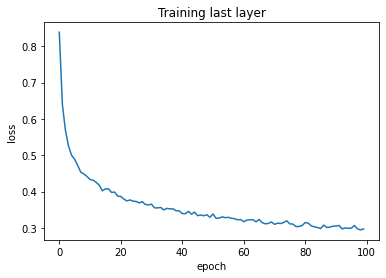

In [21]:
    i=0
    fold='fold_'+str(i+1)
    plt.plot(history_last[fold]['loss'])
    plt.title('loss for fold '+str(i))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training last layer')
    plt.show()

Training accuracy for different training methods



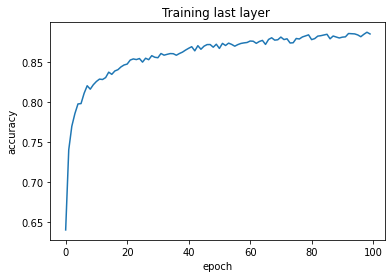

In [22]:
    i=0
    fold='fold_'+str(i+1)
    plt.plot(history_last[fold]['accuracy'])
    plt.title('loss for fold '+str(i))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Training last layer ')
    plt.show()


Validation loss for different training methods



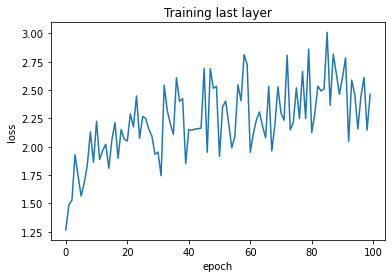

In [23]:
    i=0
    fold='fold_'+str(i+1)
    plt.plot(history_last[fold]['val_loss'])
    plt.title('loss for fold '+str(i))
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training last layer')
    plt.show()

Validation accuracy for different training methods



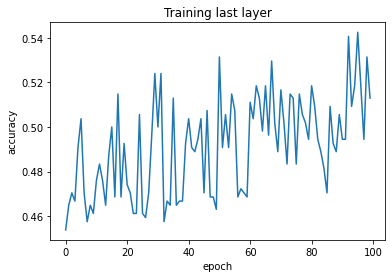

In [24]:
    i=0
    fold='fold_'+str(i+1)
    plt.plot(history_last[fold]['val_accuracy'])
    plt.title('loss for fold '+str(i))
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Training last layer')
    plt.show()

Confusion matrix best

In [25]:
from sklearn.metrics import confusion_matrix
confusion_matrix(answers_last[fold],predictions_last_best[fold])

array([[ 54,  58,   0],
       [  9, 236,   0],
       [ 73, 108,   4]])

Last confusion matrix

In [26]:

confusion_matrix(answers_last['fold_1'],predictions_last['fold_1'])

array([[ 30,  82,   0],
       [  0, 245,   0],
       [ 17, 165,   3]])

Model summary

In [27]:
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 149, 149, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

Saving results

In [0]:
path = F"/content/gdrive/My Drive" 
np.save(path+'/best_accuracy_last_fold1.npy',best_accuracy_last)
np.save(path+'/final_accuracy_last_fold1.npy',final_accuracy_last)
np.save(path+'/history_last_fold1.npy',history_last)
np.save(path+'/answers_last_fold1.npy',answers_last)
np.save(path+'/predictions_last_fold1.npy',predictions_last)
np.save(path+'/predictions_last_best_fold1.npy',predictions_last_best)
np.save(path+'/times_last_fold1.npy',times_last)